## Data Preprocessing

In [1]:
import pandas as pd

#load in data
df = pd.read_excel("final_data.xlsx")
df.head()

#transform vaccine name labels from strings to integers
df.Attitude[df.Attitude == 'Negative'] = 0
df.Attitude[df.Attitude == 'Neutral'] = 1
df.Attitude[df.Attitude == 'Positive'] = 2

#split into train, test files 
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2)


print("Length of traning dataset: ", len(train))
print("Length of testing dataset: ", len(test))

train.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Length of traning dataset:  5166
Length of testing dataset:  1292


,text,Record,Vaccine Name,Willingness,Attitude
1354,They haven’t confirmed the quantity or the bra...,6699,AstraZeneca,Not sure,1
5775,"For a lot of countries, Sinovac is the ONLY va...",9182,Sinovac,Not sure,1
6405,idk why people think we dont want sinovac caus...,10186,Sinovac,Not sure,1
5565,This list of flags is misleading. A lot of vac...,8802,Sinovac,Not sure,1
5075,Have there been good numbers released on how e...,8014,Sinovac,Not sure,1


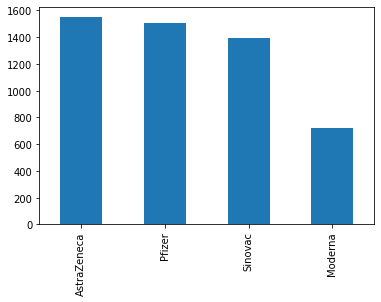

In [2]:
train["Vaccine Name"].value_counts().plot(kind='bar')

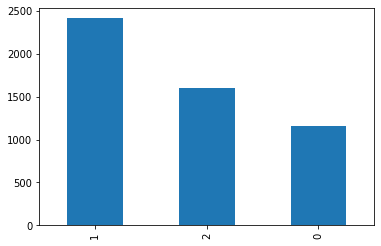

In [3]:
train['Attitude'].value_counts().plot(kind='bar')

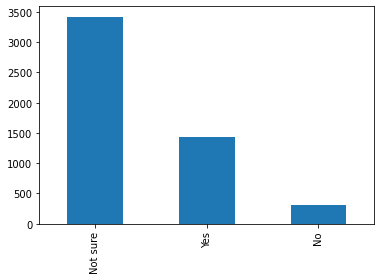

In [4]:
train['Willingness'].value_counts().plot(kind='bar')

In [5]:
import numpy as np

seq_len = 512
num_samples = len(df)

num_samples, seq_len

(6458, 512)

In [6]:
!pip install transformers
from transformers import BertTokenizer

# initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# tokenize - this time returning Numpy tensors
tokens = tokenizer(df['text'].tolist(), max_length=seq_len, truncation=True,
                   padding='max_length', add_special_tokens=True,
                   return_tensors='np')

     |████████████████████████████████| 3.4 MB 29.2 MB/s 
     |████████████████████████████████| 895 kB 54.2 MB/s 
     |████████████████████████████████| 67 kB 7.1 MB/s 
     |████████████████████████████████| 3.3 MB 63.7 MB/s 
     |████████████████████████████████| 596 kB 59.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:

tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [10]:
tokens['input_ids'][:10]



array([[  101,  1573,   117, ...,     0,     0,     0],
       [  101,  1109, 20034, ...,     0,     0,     0],
       [  101,  1109,  2233, ...,     0,     0,     0],
       ...,
       [  101,  1327,  1195, ...,     0,     0,     0],
       [  101, 11750,   117, ...,     0,     0,     0],
       [  101,  1247,  1110, ...,     0,     0,     0]])

In [11]:
tokens['attention_mask'][:10]

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [12]:
with open('attitude-xids.npy', 'wb') as f:
    np.save(f, tokens['input_ids'])
with open('attitude-xmask.npy', 'wb') as f:
    np.save(f, tokens['attention_mask'])

In [13]:
_#extract vaccine name column
arr = df['Attitude'].values.astype(int)

In [15]:
#we then initialize the zero array
labels = np.zeros((num_samples, arr.max()+1))
labels.shape

(6458, 3)

In [17]:
labels[np.arange(num_samples), arr] = 1

labels

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [18]:
with open('attitude-labels.npy', 'wb') as f:
    np.save(f, labels)

## Input Pipeline

In [19]:
import numpy as np

with open('attitude-xids.npy', 'rb') as f:
    Xids = np.load(f, allow_pickle=True)
with open('attitude-xmask.npy', 'rb') as f:
    Xmask = np.load(f, allow_pickle=True)
with open('attitude-labels.npy', 'rb') as f:
    labels = np.load(f, allow_pickle=True)

In [20]:

import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

dataset.take(1)

<TakeDataset shapes: ((512,), (512,), (3,)), types: (tf.int64, tf.int64, tf.float64)>

In [21]:

def map_func(input_ids, masks, labels):
    # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# then we use the dataset map method to apply this transformation
dataset = dataset.map(map_func)

dataset.take(1)

<TakeDataset shapes: ({input_ids: (512,), attention_mask: (512,)}, (3,)), types: ({input_ids: tf.int64, attention_mask: tf.int64}, tf.float64)>

In [22]:

batch_size = 8

dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)

dataset.take(1)

<TakeDataset shapes: ({input_ids: (8, 512), attention_mask: (8, 512)}, (8, 3)), types: ({input_ids: tf.int64, attention_mask: tf.int64}, tf.float64)>

In [23]:
split = 0.9

# we need to calculate how many batches must be taken to create 90% training set
size = int((Xids.shape[0] / batch_size) * split)

size

726

In [24]:
train_ds = dataset.take(size)
val_ds = dataset.skip(size)

In [25]:

tf.data.experimental.save(train_ds, 'train')
tf.data.experimental.save(val_ds, 'val')

In [26]:

train_ds.element_spec

({'attention_mask': TensorSpec(shape=(8, 512), dtype=tf.int64, name=None),
  'input_ids': TensorSpec(shape=(8, 512), dtype=tf.int64, name=None)},
 TensorSpec(shape=(8, 3), dtype=tf.float64, name=None))

In [27]:
val_ds.element_spec == train_ds.element_spec

True

In [28]:
ds = tf.data.experimental.load('train', element_spec=train_ds.element_spec)

## Build and Train

In [ ]:

from transformers import TFAutoModel

bert = TFAutoModel.from_pretrained('bert-base-cased')

# we can view the model using the summary method
bert.summary()


Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import tensorflow as tf

# two input layers, we ensure layer name variables match to dictionary keys in TF dataset
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int64')
mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int64')

# we access the transformer model within our bert object using the bert attribute (eg bert.bert instead of bert)
embeddings = bert.bert(input_ids, attention_mask=mask)[1]  # access final activations (alread max-pooled) [1]
# convert bert embeddings into 3 output classes
x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
y = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(x)

In [ ]:
# initialize model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# (optional) freeze bert layer
#model.layers[2].trainable = False

# print out model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=1e-5, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
element_spec = ({'input_ids': tf.TensorSpec(shape=(8, 512), dtype=tf.int64, name=None),
                 'attention_mask': tf.TensorSpec(shape=(8, 512), dtype=tf.int64, name=None)},
                tf.TensorSpec(shape=(8, 3), dtype=tf.float64, name=None))

# load the training and validation sets
train_ds = tf.data.experimental.load('train', element_spec=element_spec)
val_ds = tf.data.experimental.load('val', element_spec=element_spec)

# view the input format
train_ds.take(1)

<TakeDataset shapes: ({input_ids: (8, 512), attention_mask: (8, 512)}, (8, 3)), types: ({input_ids: tf.int64, attention_mask: tf.int64}, tf.float64)>

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3
726/726 [==============================] - 1277s 2s/step - loss: 0.9533 - accuracy: 0.5399 - val_loss: 0.7491 - val_accuracy: 0.6744
Epoch 2/3
726/726 [==============================] - 1263s 2s/step - loss: 0.7372 - accuracy: 0.6768 - val_loss: 0.5001 - val_accuracy: 0.8164
Epoch 3/3
726/726 [==============================] - 1263s 2s/step - loss: 0.5010 - accuracy: 0.8060 - val_loss: 0.3277 - val_accuracy: 0.8873


In [ ]:
model.save('Bert_Attitude_model-88%')


INFO:tensorflow:Assets written to: Bert_Attitude_model-88%/assets


INFO:tensorflow:Assets written to: Bert_Attitude_model-88%/assets
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


## Load and Predict

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('Bert_Attitude_model-88%')

# view model architecture to confirm we have save and loaded correctly
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def prep_data(text):
    tokens = tokenizer.encode_plus(text, max_length=512,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    # tokenizer returns int32 tensors, we need to return float64, so we use tf.cast
    return {'input_ids': tf.cast(tokens['input_ids'], tf.float64),
            'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)}

In [ ]:
# 0 negative, 1 neutral, 2 positive
probs0 = model.predict(prep_data("I'm excited that I'm finally getting Pfizer"))[0]
probs1 = model.predict(prep_data("The side effects are so annoying"))[0]
probs2 = model.predict(prep_data("The government started distributing AstraZeneca vaccines."))[0]



print(np.argmax(probs0), np.argmax(probs1), np.argmax(probs2))

2 1 1


In [ ]:
#transforming first time run
!zip -r /content/Bert_Attitude_model-88%.zip /content/Bert_Attitude_model-88%

from google.colab import files
files.download("/content/Bert_Attitude_model-88%.zip")


  adding: content/Bert_Attitude_model-88%/ (stored 0%)
  adding: content/Bert_Attitude_model-88%/saved_model.pb (deflated 92%)
  adding: content/Bert_Attitude_model-88%/assets/ (stored 0%)
  adding: content/Bert_Attitude_model-88%/variables/ (stored 0%)
  adding: content/Bert_Attitude_model-88%/variables/variables.index (deflated 80%)
  adding: content/Bert_Attitude_model-88%/variables/variables.data-00000-of-00001 (deflated 16%)
  adding: content/Bert_Attitude_model-88%/keras_metadata.pb (deflated 95%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>